In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
df = pd.read_csv('./recording/driving_log.csv', 
                 names=['centre_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'break', 'speed'])
print(df.shape)
df.head(2)

(338, 7)


,centre_image,left_image,right_image,steering_angle,throttle,break,speed
0,D:\SDCND\beta-simulator-windows\recording\IMG\...,D:\SDCND\beta-simulator-windows\recording\IMG\...,D:\SDCND\beta-simulator-windows\recording\IMG\...,0.0,0.06132,0,2.300570
1,D:\SDCND\beta-simulator-windows\recording\IMG\...,D:\SDCND\beta-simulator-windows\recording\IMG\...,D:\SDCND\beta-simulator-windows\recording\IMG\...,0.0,0.00000,0,2.286362


In [3]:
# D:\SDCND\beta-simulator-windows\recording\IMG\center_2017_02_14_22_05_18_509.jpg

# DataFrame.replace(to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad', axis=None)
# df['centre_image'] = df['centre_image'].replace('\\', '/')
df = df.replace(to_replace="D:\\\\SDCND\\\\beta-simulator-windows", value='.', regex=True).replace(to_replace='\\\\', value='/', regex=True)
df.head(2)

,centre_image,left_image,right_image,steering_angle,throttle,break,speed
0,./recording/IMG/center_2017_02_14_22_04_53_700...,./recording/IMG/left_2017_02_14_22_04_53_700.jpg,./recording/IMG/right_2017_02_14_22_04_53_700.jpg,0.0,0.06132,0,2.300570
1,./recording/IMG/center_2017_02_14_22_04_53_769...,./recording/IMG/left_2017_02_14_22_04_53_769.jpg,./recording/IMG/right_2017_02_14_22_04_53_769.jpg,0.0,0.00000,0,2.286362


./recording/IMG/center_2017_02_14_22_05_05_030.jpg
(160, 320, 3)


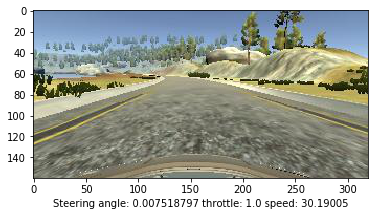

In [4]:
def show_image(index):
    print(df['centre_image'][index])
    image = mpimg.imread(df['centre_image'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} throttle: {} speed: {}".format(df['steering_angle'][index], df['throttle'][index], df['speed'][index]))

show_image(152)

(array([   9.,    2.,    8.,    6.,   14.,   32.,   46.,  110.,   87.,   24.]),
 array([-0.3759399 , -0.33007523, -0.28421057, -0.2383459 , -0.19248124,
        -0.14661657, -0.1007519 , -0.05488724, -0.00902257,  0.03684209,
         0.08270676]),
 <a list of 10 Patch objects>)

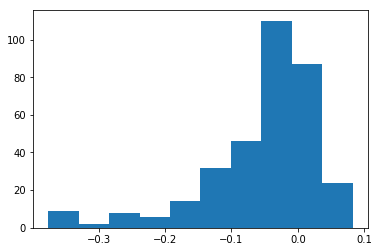

In [5]:
plt.hist(df['steering_angle'])

(array([  11.,    1.,    0.,    1.,    0.,    1.,    0.,    0.,    1.,  323.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

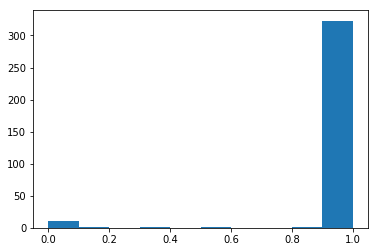

In [6]:
plt.hist(df['throttle'])

In [7]:
# get images and labels
x = []
for path in df['centre_image']:
    img = mpimg.imread(path)
    x.append(img)
print(len(x))
x = np.stack(x)
print(x.shape)

y = df.as_matrix(columns=['steering_angle', 'throttle'])
print(y.shape)
print(y[10:15])

338
(338, 160, 320, 3)
(338, 2)
[[ 0.          0.        ]
 [ 0.          0.1147694 ]
 [ 0.          0.3509103 ]
 [-0.03007519  0.579947  ]
 [-0.1353384   0.8578075 ]]


In [8]:
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

x_normalized = normalize_grayscale(x)

In [9]:
# TODO: Build a model
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 1, 1, border_mode='same', input_shape=(160,320,3)))
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2), border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2), border_mode='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))


# TODO: Compile and train the model
model.compile('adam', 'mse', ['accuracy'])

history = model.fit(x_normalized, y, batch_size=64, nb_epoch=10, validation_split=0.2)


Using TensorFlow backend.


Train on 270 samples, validate on 68 samples
Epoch 1/10
270/270 [==============================] - 14s - loss: 0.0876 - acc: 0.8444 - val_loss: 4.0612e-04 - val_acc: 1.0000
Epoch 2/10
270/270 [==============================] - 6s - loss: 0.0292 - acc: 0.9630 - val_loss: 4.0612e-04 - val_acc: 1.0000
Epoch 3/10
270/270 [==============================] - 6s - loss: 0.0292 - acc: 0.9630 - val_loss: 4.0612e-04 - val_acc: 1.0000

In [10]:
model.save('./model.h5')

OSError: Can't prepare for writing data (File write failed: time = wed feb 15 22:55:29 2017
, filename = './model.h5', file descriptor = 64, errno = 28, error message = 'no space left on device', buf = 0x7f2de1acbc28, total write size = 357770216, bytes this sub-write = 357770216, bytes actually written = 18446744073709551615, offset = 902434816)

In [11]:
!chmod +755 model.h5

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [56]:
result = model.evaluate(x_normalized, y, batch_size=128)

print(model.metrics_names)
print(result)

338/338 [==============================] - 3s     
['loss', 'acc']
[-0.89385614777810474, 0.97041420118343191]


In [ ]:
# TODO: Load test data
with open('test.p', 'rb') as f:
    data = pickle.load(f)

# TODO: Load the feature data to the variable X_train
X_test = data['features']

# TODO: Load the label data to the variable y_train
y_test = data['labels']
    
# TODO: Preprocess data & one-hot encode the labels
X_test_normalized = normalize_grayscale(X_test)
y_test_one_hot = label_binarizer.fit_transform(y_test)

# TODO: Evaluate model on test data
result = model.evaluate(X_test_normalized, y_test_one_hot, batch_size=128)

print(model.metrics_names)
print(result)